# LABORATORIO N°1 "MACHINE LEARNING AVANZADO"

In [2]:
# Importando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## <font color='blue'>**Introducción**</font>

Para cierta base de datos que posee una variable dependiente o target de tipo binaria (2 posibles clases) se pide adaptar un modelo de Red Neuronal artificial (tipo perceptrón multicapa) que permita clasificar adecuadamente ambas clases.

El dataset corresponde a una conjunto de pasajeros del famoso barco Titanic, en donde las variables independientes son las distintas características de cada uno (edad, género, clase, entre otros) y la variable dependiente tiene relación a si dicho pasajero sobrevivió o no al hundimiento del barco acaecido en 1912. Ésta toma 2 posibles valores:
- **Valor 0** --> si pasajero NO sobrevivió
- **Valor 1** --> si pasajero SÍ sobrevivió

La idea subyacente es que ciertas combinación de características del pasajero me permitirán predecir de manera bastante certera si sobrevivió al naufragio o no, dado que existe evidencia, por ejemplo, de que clases más altas tenían prioridad en la evacuación, así como mujeres y niños.

La data se encuentra disponible en:

[https://www.kaggle.com/competitions/titanic/data](https://www.kaggle.com/competitions/titanic/data)

Los archivos que componen la data:

1. ***train.csv***: archivo con 891 personas, identificadas con su ID, 10 variables dependientes o descriptivas, además de la variable tarjet SURVIVED (0 ó 1).

2. ***test.csv***: archivo con 418 personas identificadas con su ID además de sus 10 variables dependientes o descriptivas

3. ***gender_submission.csv***: variable que posee un ejemplo a cómo subir la variable target de la base test.


Esta data está confeccionada para una competición en Kaggle, para generar el mejor modelo predictivo de esos datos. Por tanto, **los datos de test.csv NO incluyen la variable target (SURVIVED) real**. El archivo gender_submission.csv sólo incluye un ejemplo de cómo generar el archivo (que en teoría debe ser subido por los competidores), pero esa variable no corresponde a la real (de hecho en la descripción se menciona "For the test set, we do not provide the ground truth for each passenger"). Es más, esa variable output de ejemplo está hecha bajo el supuesto de que mujeres sobreviven y hombres fallecen.


Dado esto, <font color='blue'>**sólo contamos con los 891 casos de la base train**</font> para entrener y testear nuestro modelo de RNA.








## <font color='blue'>**I. Carga de Datos**</font>

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Cargando los datasets
train_data = pd.read_csv('PATH_FILE/train.csv', sep=",", decimal=".")


In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
print(train_data.shape)
# Aqui validamos que estamos ante 891 casos, en donde se tienen 12 columnas por observación

(891, 12)


## <font color='blue'>**II. Análisis Exploratorio de Datos (EDA)**</font>

### <font color='blue'>**a. Variables: descripción y tipos**</font>

In [44]:
#Para conocer lso tipos de columnas:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Se tienen las siguientes variables:

**PassengerId:** ID del pasajero. Aparece como tipo entero, pero en realidad correspondería que fuera de tipo objeto. NO corresponde a una variable independiente, pues sólo sirve para identificar la fila.

**Survived:** Variable dependiente o target que indica si pasajero sobrevivió o no. Es de tipo entero, pudiendo tomar valor 1 (si sobrevivió) ó 0 (si NO sobrevivió).

**Pclass:** Variable independiente, corresponde a la clase de ticket (y por tanto es un proxy del status socioeconómico de la persona). Es de tipo entero, pudiendo tomar valores:
- 1: Primera clase (clase alta)
- 2: Segunda clase (clase media)
- 3: Tercera clase (clase baja)


**Name:** Nombre del pasajero. Variable tipo objeto.

**Sex:** Variable independiente, corresponde al género del pasajero. Sus posibles valores: {male,female}.

**Age:** Variable independiente, corresponde a la edad del pasajero. Variable de tipo flotante.

**SibSp:** Variable independiente, corresponde al número de hermanos/cónyuges a bordo del Titanic. Variable de tipo entero.

**Parch:** Variable independiente, corresponde al número de padres/hijos a bordo del Titanic. Variable de tipo entero. Si el niño viajaba solo con la niñera, su valor PARCH será igual a 0.

**Ticket:** Variable independiente, corresponde al código del ticket. Variable de tipo objeto.

**Fare:** Variable independiente, corresponde a la tarifa pagada por el pasajero. Variable de tipo flotante.

**Cabin:** Variable independiente, corresponde al número de la cabina del pasajero. Variable de tipo objeto.

**Embarked:** Variable independiente, corresponde al puerto en que se embarcó el pasajero. Variable de tipo objeto que posee 3 posibles valores:
- C: Cherbourg
- Q: Queenstown
- S: Southampton


Del análisis anterior se desprende que PASSANGERID y NAME no aportarán mucho al modelo por ser variables únicas e identificatorias de cada fila. Por tanto, creamos nuevos dataframes excluyendo estas variables:

In [8]:
#DATAFRAME  queda con 10 columnas (1 dependiente + 9 independientes):
data = train_data.drop(['PassengerId','Name'], axis=1)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


### <font color='blue'>**b. Análisis estadístico descriptivo de variables numéricas:**</font>

In [9]:
print("Descripción estadística del conjunto de datos de entrenamiento (variables numércicas):")
data[['Pclass','Age','SibSp','Parch','Fare']].describe()


Descripción estadística del conjunto de datos de entrenamiento (variables numércicas):


,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200




*   En PCLASS se tiene que su promedio es 2.3, lo que habla de una mayor presencia de pasajeros de clase baja que de clase alta. Esto se confirma al ver los cuartiles: la clase 3 la más numerosa al estar presente ya desde el cuartil 50%.


*   En AGE se tiene un promedio de edad de 29.7 años, con personas que iban desde los recién nacidos hasta de 80 años. Que el cuartil 2 sea 28 implica que al menos la mitad del grupo era menor de 28 años, lo que habla de un rango etario bastante joven.

*   En SIBSP se tiene que las personas viajaban con 0 a 8 hermanos/cónyuges, siendo el cuartil 2 de 0 (es decir, la mayoría viajaba sin hermanos ni cónyuges).

*   En PARCH se tiene que las personas viajaban con 0 a 6 padres/hijos siendo el cuartil 3 de 0 (es decir, al menos el 75% del grupo viajaba sin padres ni hijos).

*   En FARE la tarifa cancelada fluctúa entre 0 y 512.33, con un cuartil 2 de 14.5 (es decir, la mitad de los pasajeros pagó a lo más 14.5).







Por otra parte, si para estas mismas variables numéricas visualizamos sus correlaciones:

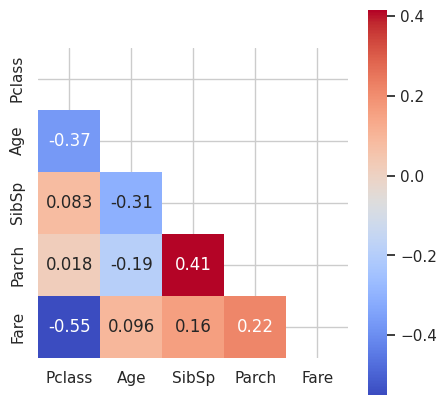

In [47]:
sub_df = data[['Pclass','Age','SibSp','Parch','Fare']]

plt.figure(figsize=(5,5))
mask = np.triu(np.ones_like( sub_df.corr(), dtype=bool))
sns.heatmap(data= sub_df.corr(), annot=True, square=True, cmap='coolwarm', mask=mask)
plt.show()

Vemos como las principales magnitudes que resaltan:

- Entre **FARE-PCLASS**: -0.55 --> habla de una correlación negativa media entre la tarifa la clase, lo que resulta lógico pues la tendencia debiese ser que a menor clase (o sea clase más alta), más costó el ticket.

- Entre **PARCH y SIBSP**: 0.41 --> habla de una correlación positiva débil entre N° de hermanos/cónyuges con lo que viaja el pasajero  y el N° de padres/hijos. Aquí se puede deducir que las personas que viajaban acompañados o en familia, en general tendían a hacerlo tanto con hijos/padres como con parejas/hermanos.

### <font color='blue'>**c. Variable dependientes SURVIVED**</font>

Con respecto a la variable dependiente que indica la sobrevivencia del pasajero se tiene que la mayoría del grupo (61,6%) no logró sobrevivir.

+----+------------+
|    |   Survived |
|----+------------|
|  0 |        549 |
|  1 |        342 |
+----+------------+


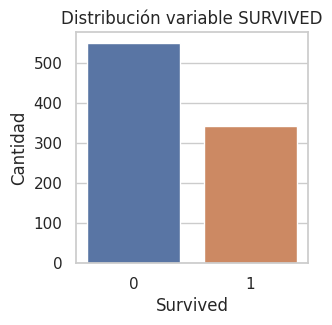

In [102]:
# Configuramos el estilo de los gráficos
sns.set(style='whitegrid')

tabla = train_data['Survived'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Survived'])
print(tabulate(tabla_df,headers="keys",tablefmt='psql'))


# Sobrevivientes por género
plt.figure(figsize=(3,3))
sns.countplot(x='Survived', data=train_data)
plt.title('Distribución variable SURVIVED')
plt.ylabel('Cantidad')
plt.show()


### <font color='blue'>**d. Análisis univariado de variables independientes**</font>

### <font color='blue'>1. Variable PCLASS:</font>

Con respecto a la variable que da cuenta de la clase del pasajero, se tiene que:
- La clase 2 (media) es la de menor presencia con el 20,7% del total
- La clase 1 o primera clase (alta) sigue en importancia con 24,2%.
- La clase con más presencia en el barco es la tercera clase (baja) com el 55,1% del total.  


Por otra parte, al observar la sobrevivencia por clase, como era de esperar se tiene que a mejor clase, mayor fue la tasa de sobrevivencia (posiblemente por dar prioridad a las clases más acomodadas en la evacuación).

+----+----------+
|    |   Pclass |
|----+----------|
|  1 |      216 |
|  2 |      184 |
|  3 |      491 |
+----+----------+


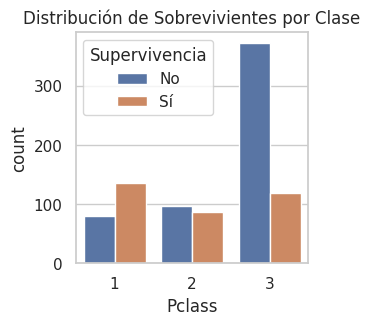

In [100]:
# Configuramos el estilo de los gráficos
sns.set(style='whitegrid')

tabla = train_data['Pclass'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Pclass']).sort_index()
print(tabulate(tabla_df,headers="keys",tablefmt='psql'))


# Sobrevivientes por género
plt.figure(figsize=(3,3))
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Distribución de Sobrevivientes por Clase')
plt.legend(title='Supervivencia', labels=['No', 'Sí'])
plt.show()


### <font color='blue'>2. Variable SEX:</font>

A continuación vemos cómo en la variable SEX la mayoría de los pasajeros (64,8%) eran hombres.

Por otra parte, resulta evidente al analizar la tasa de supervivencia por género, que de los sobreviviente la mayoría fueron mujeres. Más aún, la mayoría de las mujeres sobrevivió, mientras que por el contrario, la mayoría de los hombres falleció.

+--------+-------+
|        |   Sex |
|--------+-------|
| male   |   577 |
| female |   314 |
+--------+-------+


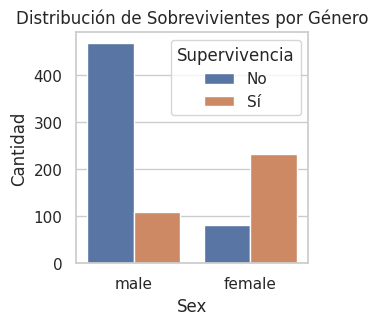

In [101]:
# Configuramos el estilo de los gráficos
sns.set(style='whitegrid')

tabla = train_data['Sex'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Sex'])
print(tabulate(tabla_df,headers="keys",tablefmt='psql'))


# Sobrevivientes por género
plt.figure(figsize=(3,3))
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('Distribución de Sobrevivientes por Género')
plt.ylabel('Cantidad')
plt.legend(title='Supervivencia', labels=['No', 'Sí'])
plt.show()



### <font color='blue'>3. Variable TICKET:</font>

Sabemos que TICKET es una variable de tipo objeto que indica el código del ticket de embarque. Al realizar una tabla de frecuencia para ver cuántos tickets se repiten n veces, se obtuvo que la mayoría sólo está presente 1 vez en el dataset (547 casos, es decir, el 61,4%). El resto se repite de 2 a 7 veces. Realizando una inspección a lso casos que se repite y los nombres de los pasajeros, se tiene que posiblemente los grupos familiares viajaban bajo un mismo ticket.

In [76]:
tabla = train_data['Ticket'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Ticket']).sort_index()
tabla2 = tabla_df['Ticket'].value_counts()
tabla_df2=pd.DataFrame(tabla2, columns=['Ticket']).sort_index()
tabla_df2.columns = ['Frecuencia']
tabla_df2.index.name = 'Nro_repeticiones'
print(tabulate(tabla_df2,headers="keys",tablefmt='psql'))



+--------------------+--------------+
|   Nro_repeticiones |   Frecuencia |
|--------------------+--------------|
|                  1 |          547 |
|                  2 |           94 |
|                  3 |           21 |
|                  4 |           11 |
|                  5 |            2 |
|                  6 |            3 |
|                  7 |            3 |
+--------------------+--------------+


### <font color='blue'>4. Variable CABIN:</font>

**Llama la atención que el 77,1% de los pasajeros posean valor nulo en  esta variable:**

In [81]:
print('N° valores nulos:')
print(train_data['Cabin'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['Cabin'].isnull().sum()/891)

N° valores nulos:
687

% de valores nulos:
0.7710437710437711


**Una hipótesis es que sólo las mejores clases (primera y segunda) contaban con cabina, mientras que la tercera clase no. Comprobémoslo:**

In [90]:
df_aux = train_data[train_data['Cabin'].notnull()]

tabla1 = train_data['Pclass'].value_counts()
tabla_df1=pd.DataFrame(tabla1, columns=['Pclass']).sort_index()

tabla2 = df_aux['Pclass'].value_counts()
tabla_df2=pd.DataFrame(tabla2, columns=['Pclass']).sort_index()

tabla_df = pd.DataFrame()
tabla_df['n_total'] = tabla_df1['Pclass']
tabla_df['n_cabina_NO_NULA']=tabla_df2['Pclass']
tabla_df['porc_cabina_no_nula'] = tabla_df['n_cabina_NO_NULA']/tabla_df['n_total']
tabla_df.index.name = 'Pclass'
tabla_df

,n_total,n_cabina_NO_NULA,porc_cabina_no_nula
Pclass,,,
1,216,176,0.814815
2,184,16,0.086957
3,491,12,0.024440


**Del cuadro anterior se puede extraer cómo la hipótesis no estaba tan lejos de la realidad. EL 81,5% de la primera clase presenta alguna cabina registrada, mientras que el porcentaje desciende abruptamente para la segunda (8,7%) y tercera (2,4%)**

### <font color='blue'>5. Variable EMBARKED:</font>

**Esta variable presenta sólo 2 valores nulos. Además la mayoría de los pasajeros (más del 72%) se embarcaron en Southampton:**

In [93]:

print('N° valores nulos:')
print(train_data['Embarked'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['Embarked'].isnull().sum()/891)
print('')

tabla = train_data['Embarked'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Embarked']).sort_index()

print(tabulate(tabla_df,headers="keys",tablefmt='psql'))


N° valores nulos:
2

% de valores nulos:
0.002244668911335578

+----+------------+
|    |   Embarked |
|----+------------|
| C  |        168 |
| Q  |         77 |
| S  |        644 |
+----+------------+


**Al ver la tasa de sobrevivencia, resulta evidente de la gráfica que la peor tasa la tienen los embarcados en Southampton, por el contrario la mejor tasa de sobrevivencia la tienen los embarcados en Cherbourg.**

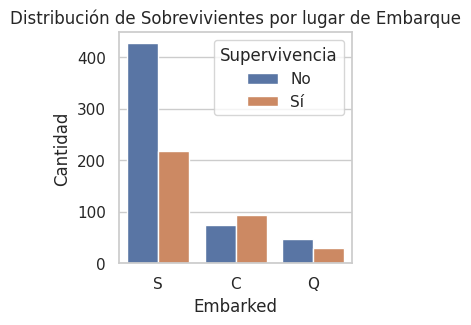

In [98]:
# Sobrevivientes por embarque
plt.figure(figsize=(3,3))
sns.countplot(x='Embarked', hue='Survived', data=train_data)
plt.title('Distribución de Sobrevivientes por lugar de Embarque')
plt.ylabel('Cantidad')
plt.legend(title='Supervivencia', labels=['No', 'Sí'])
plt.show()


**Quizá el lugar de embarque dice algo de la clase de la persona. Veamos la distribución de las clases según lugar de embarque:**

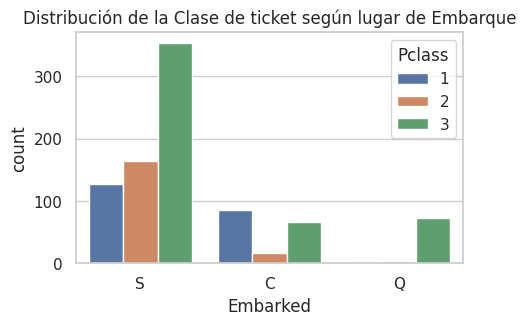

In [104]:
plt.figure(figsize=(5,3))
sns.countplot(x='Embarked', hue='Pclass', data=train_data)
plt.title('Distribución de la Clase de ticket según lugar de Embarque')
plt.show()


**Hay coherencia en los resultados pues se ve, que en términos proporcionales, C presenta una mayor proporción de primera clase, mientras que S de tercera clase, y en Q sólo embarcó tercera clase.  Por tanto embarques con mayor presencia de tickets de primera clase,  tienden a tener mayor proporción de salvados.**

### <font color='blue'>6. Variable AGE:</font>

Un 19,9% de los casos no tiene dato de edad:

In [112]:
print('N° valores nulos:')
print(train_data['Age'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['Age'].isnull().sum()/891)
print('')


N° valores nulos:
177

% de valores nulos:
0.19865319865319866



Para los casos en que sí hay dato de edad, se tiene que la distribución de ambos universos: sobreviven y no sobreviven, es similar en forma. Ambos grupos poseen mediana = 28

Además, en la mayoría de los tramos de edad es mayor la cantidad de fallecidos que de sobrevivientes. La mayoría de las excepciones están en los tramos menores de edad (niños) de lo que se deduce les otorgaron prioridad para evacuar:

La mediana de edad del grupo que NO sobrevive es 28.0
La mediana de edad del grupo que SÍ sobrevive es 28.0



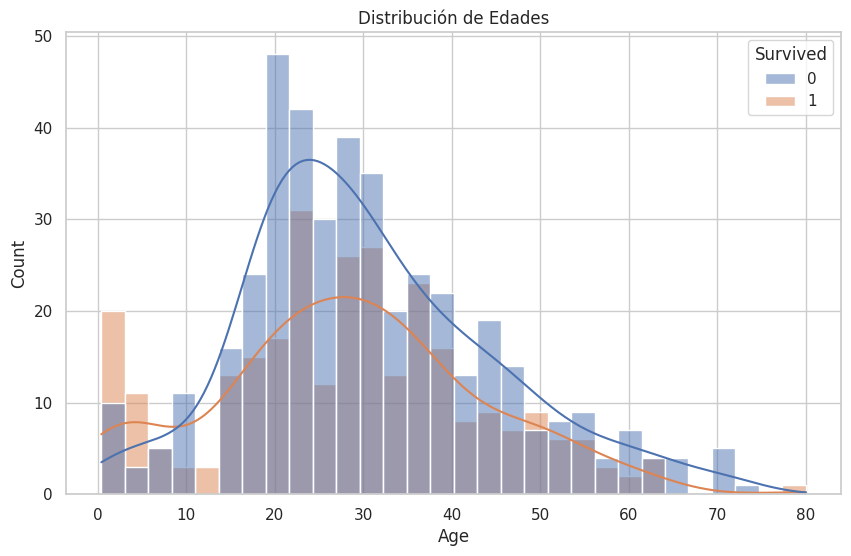

In [126]:
df_aux = train_data[train_data['Age'].notnull()] #excluyo filas con valores de edad nulos.
m0=df_aux[df_aux['Survived']==0]['Age'].median()
m1=df_aux[df_aux['Survived']==1]['Age'].median()

print(f'La mediana de edad del grupo que NO sobrevive es {m0}')
print(f'La mediana de edad del grupo que SÍ sobrevive es {m1}')
print('')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_aux , x='Age', hue='Survived', kde=True, bins=30)
plt.title('Distribución de Edades')

plt.show()

Si se desea ver la tasa de supervivencia entre niños y adultos:

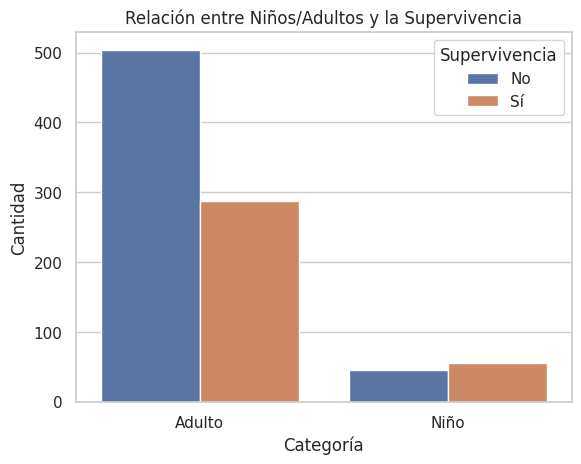

In [132]:
# Definir un límite de edad para clasificar a los pasajeros como niños o adultos
limite_edad = 16

# Crear una nueva columna 'Niño_Adulto'
train_data['Niño_Adulto'] = np.where(train_data['Age'] <= limite_edad, 'Niño', 'Adulto')

# Visualización comparando la tasa de sobrevivientes entre niños y adultos
sns.countplot(x='Niño_Adulto', hue='Survived', data=train_data)
plt.title('Relación entre Niños/Adultos y la Supervivencia')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.legend(title='Supervivencia', labels=['No', 'Sí'])
plt.show()

**Se comprueba cómo los niños (hasta 16 años) tienen una tasa de sobrevivencia sobre el 50%, mucho mayor a la de los adultos.**

### <font color='blue'>7. Variable FARE:</font>

Esta variable no posee valores nulos:

In [144]:
print('N° valores nulos:')
print(train_data['Fare'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['Fare'].isnull().sum()/891)
print('')


N° valores nulos:
0

% de valores nulos:
0.0



Con respecto a la distribución de FARE según los 2 grupos de sobrevivencia, se tiene que los NO sobrevivientes presentan una curva más desplazada a la izquierda con una mediana de 10.5, vs la de sobrevivientes con un 26.0.

Por otra parte, en el gráfico se aprecia cómo a mayor tarifa, mayor es la proporción de personas salvadas, lo que da indicios de que se priorizó salvar a personas de mayores ingresos:

La mediana de la tarifa del grupo que NO sobrevive es 10.5
La mediana de la tarifa del grupo que SÍ sobrevive es 26.0



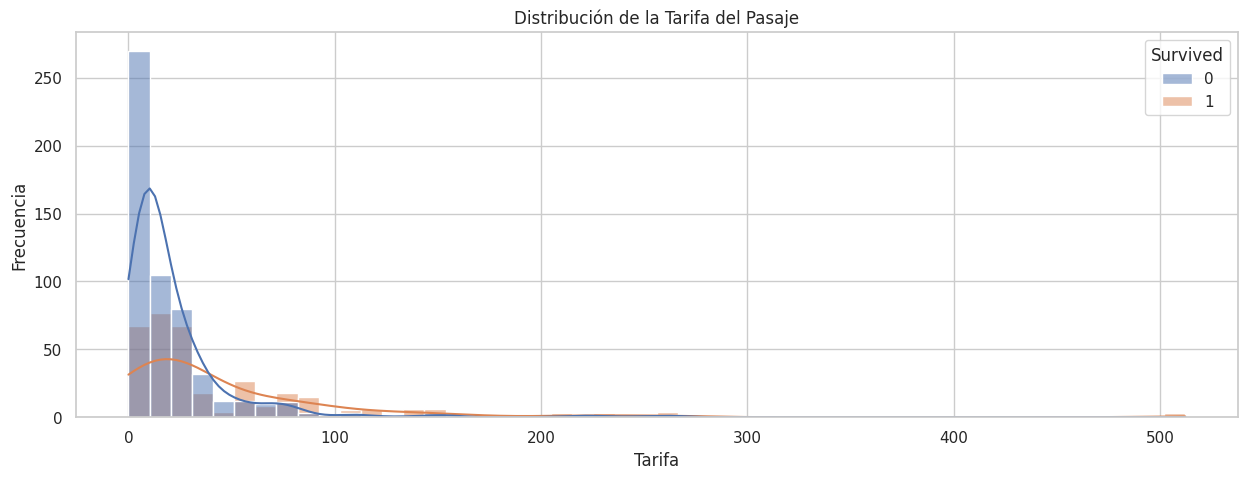

In [148]:
m0=train_data[train_data['Survived']==0]['Fare'].median();
m1=train_data[train_data['Survived']==1]['Fare'].median();

print(f'La mediana de la tarifa del grupo que NO sobrevive es {m0}')
print(f'La mediana de la tarifa del grupo que SÍ sobrevive es {m1}')
print('')

# Distribución de la tarifa del pasaje
plt.figure(figsize=(15,5))
sns.histplot(data = train_data,x='Fare',hue='Survived', kde=True, bins=50);
plt.title('Distribución de la Tarifa del Pasaje')
plt.xlabel('Tarifa')
plt.ylabel('Frecuencia')
plt.show();

Adicionalmente, si comparamos las tarifas según las distintas clases, la primera clase presenta tarifas más elevadas, pero a la vez con un rango intercuartíclico máss amplio (más dispersas).
A peor clase, el RIC se acota (tarifas más homogéneas entre sí). Probablemente a clase más alta, la tarifa podía variar más de acuerdo al grado de amenities solicitados:

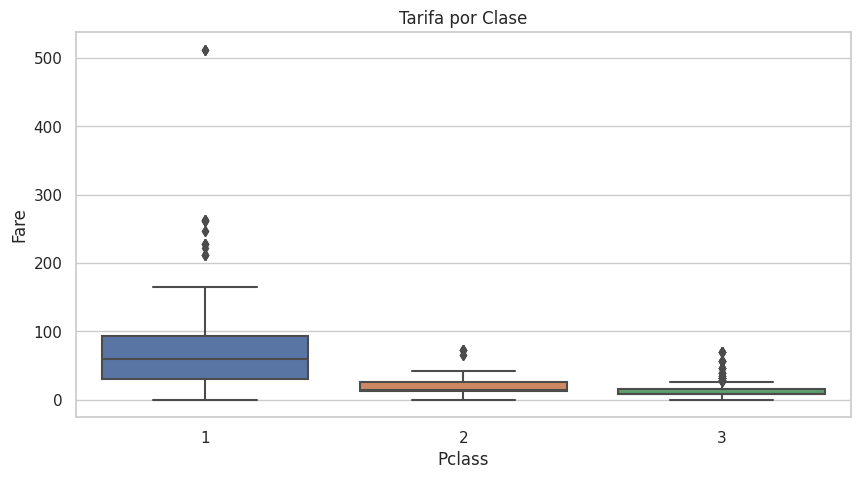

In [150]:
# Tarifa vs Clase
plt.figure(figsize=(10, 5))
sns.boxplot(x='Pclass', y='Fare', data=train_data)
plt.title('Tarifa por Clase')
plt.show()

### <font color='blue'>8. Variable SIBSP:</font>

Esta variable no posee valores nulos:

In [152]:
print('N° valores nulos:')
print(train_data['SibSp'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['SibSp'].isnull().sum()/891)
print('')


N° valores nulos:
0

% de valores nulos:
0.0



In [161]:
tabla = train_data['SibSp'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['SibSp']).sort_index()
print(tabulate(tabla_df,headers="keys",tablefmt='psql'))

+----+---------+
|    |   SibSp |
|----+---------|
|  0 |     608 |
|  1 |     209 |
|  2 |      28 |
|  3 |      16 |
|  4 |      18 |
|  5 |       5 |
|  8 |       7 |
+----+---------+


La mayoría de los pasajeros (cerca del 68%) viajaba sin hermanos ni cónyuges. La segunda mayoría (23,5%) viajaba con 1 hermano o un cónyuge.

Del gráfico resulta curioso que aquellos que viajaban con 1 ó 2 hermano/cónyuge tuvo mayor ratio de sobrevivencia que el resto:

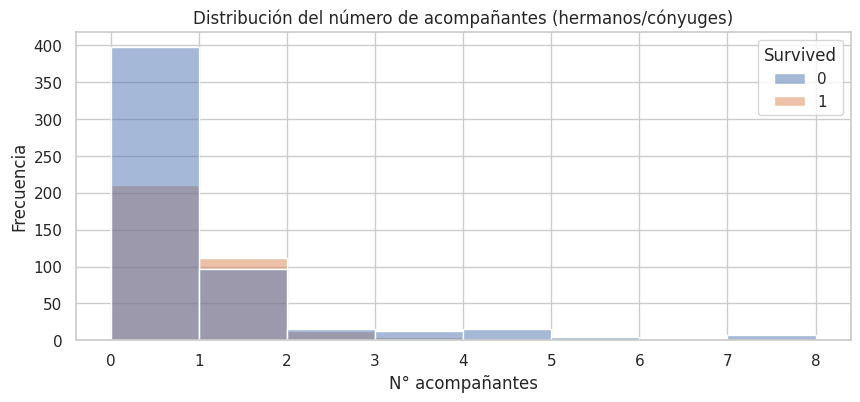

In [168]:
# Distribución del número de acompañantes (hermanos/cónyuges):
plt.figure(figsize=(10,4))
sns.histplot(data = train_data,x='SibSp', hue = 'Survived',kde=False, bins=8);
plt.title('Distribución del número de acompañantes (hermanos/cónyuges)')
plt.xlabel('N° acompañantes')
plt.ylabel('Frecuencia')
plt.show();

### <font color='blue'>9. Variable PARCH:</font>

Esta variable no posee valores nulos:

In [162]:
print('N° valores nulos:')
print(train_data['Parch'].isnull().sum())
print('')
print('% de valores nulos:')
print(train_data['Parch'].isnull().sum()/891)
print('')


N° valores nulos:
0

% de valores nulos:
0.0



In [163]:
tabla = train_data['Parch'].value_counts()
tabla_df=pd.DataFrame(tabla, columns=['Parch']).sort_index()
print(tabulate(tabla_df,headers="keys",tablefmt='psql'))

+----+---------+
|    |   Parch |
|----+---------|
|  0 |     678 |
|  1 |     118 |
|  2 |      80 |
|  3 |       5 |
|  4 |       4 |
|  5 |       5 |
|  6 |       1 |
+----+---------+


La mayoría de los pasajeros (cerca del 76%) viajaba sin padres ni hijos. La segunda mayoría (13%) viajaba con 1 padre o hijo

Del gráfico también salta a la vista que personas que viajaron 1 ó 2 acompañantes (padres/hijos) tienen mayor tasa de sobrevivencia que quienes viajaron sin ese tipo de acompañantes:

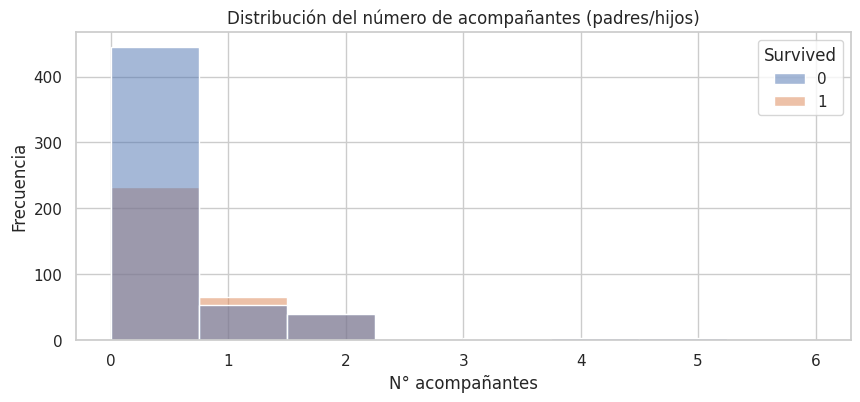

In [169]:
# Distribución del número de acompañantes padres/hijos):
plt.figure(figsize=(10,4))
sns.histplot(data = train_data,x='Parch', hue = 'Survived',kde=False, bins=8);
plt.title('Distribución del número de acompañantes (padres/hijos)')
plt.xlabel('N° acompañantes')
plt.ylabel('Frecuencia')
plt.show();

## <font color='blue'>**III. Feature Engineering (Preparación de datos para modelado)**</font>

### <font color='blue'>**a. Análisis de missing values**</font>

In [10]:
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Como se había visto en la sección anterior, 3 variables poseen al menos un valor nulo o faltante:
- AGE: 122 casos
- CABIN: 687 casos
- EMBARKED: 2 casos


Por otra parte la variable objetivo no presenta missing values.




### <font color='blue'>**b. Eliminación de características/features**</font>

1. Se había visto en el EDA que quienes presentaban valor no nulo de CABINA eran mayoritariamente primera clase. Sin embargo quedan bastantes pasajeros de primera clase sin una Cabina registrada, lo que hace poco creíble/confiable ese campo. **Por tanto, se optará por eliminar la variable CABIN.**

2. Por otra parte, la variable TICKET (de tipo categórico) presenta cerca del 40% de pasajeros con un valor de ticket que se repite, al menos una vez, para otro pasajero. Aquí la hipótesis es que las personas que viajan juntas usan el mismo ticket, pero aún así al ser categórica se hace bastante costoso convertirla en dummy para los cientos de valores que puede presentar. **Por ende se procederá a eliminar TICKET.**

In [11]:
#Elimino estas variables del DF que contiene las variables independientes:

data2 = data.drop(['Cabin','Ticket'], axis=1)
data2.head()

#Ahora tablón queda con 7 features

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### <font color='blue'>**c. Eliminación de instancias**</font>

Como sólo hay 2 filas (instancias) que poseen valor nulo en la variable EMBARKED, se procederá a eliminar estas observaciones:

In [134]:
data3 = data2.dropna(subset=['Embarked']).reset_index(drop=True) #reseteo index dado que eliminé filas
data3.shape

#Queda un tablón con 889 observaciones

(889, 8)

### <font color='blue'>**d. Creación de nueva característica**</font>

Se tienen 2 variables que dan cuenta de los acompañantes que viajaban junto con el pasajero: Sibsp y Parch. Ambos son disjuntos para cada pasajero, pues los parentescos no son intersectables. Otra ventaja es que ninguna de las 2 características presenta valores nulos.


Una potencial mejora sería crear una nueva característica que de cuenta del número de acompañantes total del pasajero (ya sea el acompañante cónyuge, hijo, padre o hermano).

**N_acompañantes = SibSp + Parch**

In [135]:
#Agregamos a Dataframe:

data3['N_acompañantes'] = data3['SibSp'] + data3['Parch']
data3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N_acompañantes
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,1
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,1
4,0,3,male,35.0,0,0,8.0500,S,0


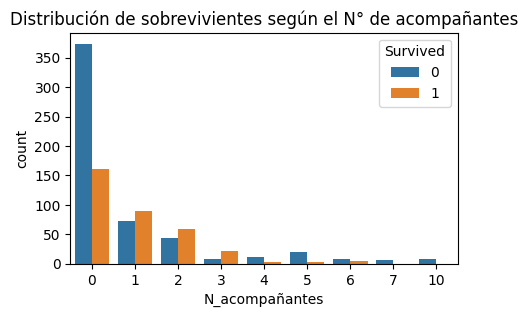

In [14]:
plt.figure(figsize=(5,3))
sns.countplot(x='N_acompañantes', hue='Survived', data=data3)
plt.title('Distribución de sobrevivientes según el N° de acompañantes')
plt.show()

#Aquí se ve como para la nueva variable, para las personas que poseen 1, 2 ó 3, el índice de sobrevivencia es mayor que el del resto.

### <font color='blue'>**e. Estandarización y creación de variables dummy**</font>



*   Con respecto a las variables categóricas (SEX, EMBARKED) convendrá convertirlas en dummy para que sean un buen input para la red neuronal. Además que estas 2 variables tengan pocos valores posibles las hace ideal para dummizar.
*   En relación a las variables numéricas (AGE, SIBSP, PARCH, FARE, PCLASS, N_ACOMPAÑANTES) también convendrá transformarlas, en este caso estandarizarlas, antes de usarlas en la RNA. Al homologar sus escalas su estandarización permitirá acelerar la convergencia y que los efectos estén en los pesos y no en los valores que toman las variables.



In [15]:
#Se instancia un preprocesador que transformará las columnas numéricas (estandarización ) y las variables catégoricas (codificación OneHot):

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SibSp', 'Parch', 'Fare','Age','N_acompañantes','Pclass']),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), ['Sex','Embarked'])
    ])

#En OneHotEncoder, con drop='first' hago que se elimine una de las variables dummy del feature, impidiendo la multicolinealidad perfecta.

In [16]:
#Variables independientes:
features = ['SibSp', 'Parch', 'Fare','Age','N_acompañantes','Pclass','Sex','Embarked']

#Aplico preprocesador a variables independientes:
data_transformada= preprocessor.fit_transform(data3[features])

#Paso a dataframe:
data4 = pd.DataFrame(data_transformada, columns=preprocessor.get_feature_names_out())
data4['Survived'] = data3['Survived']
data4.head()

,num__SibSp,num__Parch,num__Fare,num__Age,num__N_acompañantes,num__Pclass,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,Survived
0,0.431350,-0.474326,-0.500240,-0.527669,0.057853,0.825209,1.0,0.0,1.0,0
1,0.431350,-0.474326,0.788947,0.577094,0.057853,-1.572211,0.0,0.0,0.0,1
2,-0.475199,-0.474326,-0.486650,-0.251478,-0.561804,0.825209,0.0,0.0,1.0,1
3,0.431350,-0.474326,0.422861,0.369951,0.057853,-1.572211,0.0,0.0,1.0,1
4,-0.475199,-0.474326,-0.484133,0.369951,-0.561804,0.825209,1.0,0.0,1.0,0


**Tablón quedó con 9 variables independientes.**

### <font color='blue'>**f. Imputación de variable AGE**</font>

- En la columna 'Age' del dataset train.csv se presentan 177 valores faltantes de un total de 891.
- Considerando que la edad de los pasajeros puede ser un feature importante para predecir la sobrevivencia del individuo y la cantidad de valores faltantes, se optó por no eliminar las filas ni tampoco imputar los valores faltantes utilizando valores estadísticos como mediana o promedio.
- Se optó por realizar imputación de valores faltantes utilizando K-nearest Neighbors (KNN), ya que los demás features de los pasajeros pueden estar correlacionados de manera significativa. Además todas las variables ya están convertidas a numéricas, las continuas estandarizadas y el dataset no es muy grande (lo que es perfecto para KNN que no es muy eficaz en dataset muy grandes).

In [17]:
#Aquí se tienen los valores nulos de la variable AGE:
data4.isnull().sum()

num__SibSp               0
num__Parch               0
num__Fare                0
num__Age               177
num__N_acompañantes      0
num__Pclass              0
cat__Sex_male            0
cat__Embarked_Q          0
cat__Embarked_S          0
Survived                 0
dtype: int64

In [18]:
# Imputación KNN
knn_imputer = KNNImputer(n_neighbors=10) #escogemos los 10 vecinos más cercanos

data_imputada= knn_imputer.fit_transform(data4)

# Conversión a DataFrame
data5 = pd.DataFrame(data_imputada, columns=data4.columns)

#Ahora la variable AGE ya no presenta valores nulos:
data5.isnull().sum()

num__SibSp             0
num__Parch             0
num__Fare              0
num__Age               0
num__N_acompañantes    0
num__Pclass            0
cat__Sex_male          0
cat__Embarked_Q        0
cat__Embarked_S        0
Survived               0
dtype: int64

## <font color='blue'>**IV. Construcción de modelos RNA: Perceptrón multicapa**</font>

### <font color='blue'>**a. Separación base train/test**</font>

In [19]:
#Separamos variables independientes de variable objetivo

datos = data5.iloc[:, :-1] #Variables independientes
y= data5['Survived'] #Variables dependientes

In [20]:

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(datos,y,test_size=0.3,random_state=88) #dejamos 30% para test

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(622, 9)
(267, 9)
(622,)
(267,)


**Quedan 622 casos para train y 267 para test**

### <font color='blue'>**b. Ejecución de modelos**</font>

Las Redes Neuronales Artificiales pueden ser de distinto tipo según su estructura y funcionamiento. Para este problema utilizaremos la <font color='blue'>red neuronal feedforward tipo perceptrón multiple.

- Por un lado se denominan feedforward pues la información se mueve en una sola dirección (desde la capa de entrada a la capa de salida), sin presencia de bucles ni ciclos.
- Además estamos considerando las tipo perceptrón múltiple, es decir, aquellas compuestas por varias capas de perceptrones.


Este tipo de RNA resulta útil para problemas de clasificación y regresión, así que podemos aplicarla al modelo supervisado que queremos construir (en donde queremos predecir una variable binaria).

Esquema general de una red neuronal Perceptrón Multicapa:

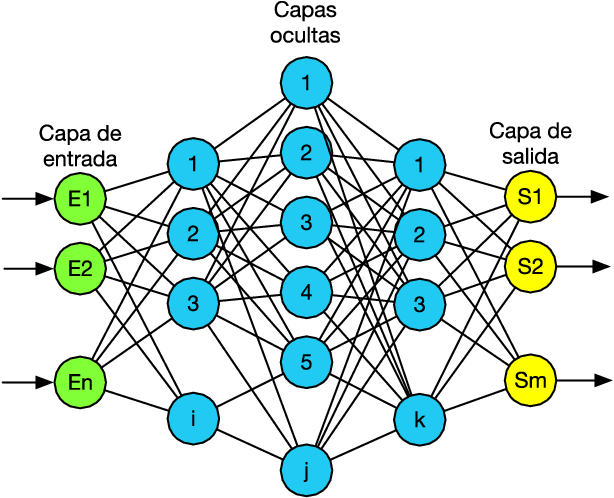

Recordemos que cada capa oculta y de salida (así como cada uno de sus nodos) está ligada a una función de activación, que en el fondo es la que permite a la red aprender y modelar relaciones no lineales en los datos.

Las principales de funciones de activación que provee la librería Keras, y que probaremos al construir el modelo, son:

1. **ReLU:** hace que el algoritmo del gradiente descendente converja mucho más rápidamente, facilitando así el entrenamiento. Una desventaja es que puede activar "neuronas muertas"

2. **Leaky ReLU:** Variante de RELU que mitiga el problema de "neuronas muertas"

3. **Sigmoide:** produce una salida en el rango (0, 1), útil en problemas de clasificación binaria

4. **Tangente hiperbólica:**produce una salida en el rango (-1, 1), útil en problemas de clasificación multiclase.

Otros parámetros/hiperparámetros a revisar:

- **epochs:** número de épocas o veces que se recorrerá todo el conjunto de entrenamiento durante el ajuste (debido al backpropagation). En este caso lo dejaremos fijo en 50 (con 50 se produce una convergencia aceptable de la función de pérdida).

- **learning_rate:** la magnitud con la que se ajustan los pesos durante el proceso de aprendizaje. Acá probaremos 2 valores: 0,01 y 0,001.

- **batch_size:**número de ejemplos de base train utilizados en una iteración del entrenamiento. Se dejará su valor fijo en 16.

- **optimizer:**el algoritmo de optimización utilizado para entrenar la red. En este caso se utilizará siempre ADAM (adaptative moment extimation) pues es de lo ma´s usados y eficientes.

Se entrenarán 18 modelos o redes, de manera de probar distintas combinaciones de parámetros: número de capas ocultas, número de nodos, learning_ratey  función de activación.

Cada modelo será evaluado de acuerdo al accuracy que arroje base test.

A continuación se presenta los distintos parámetros para los 18 modelos a entrenar:

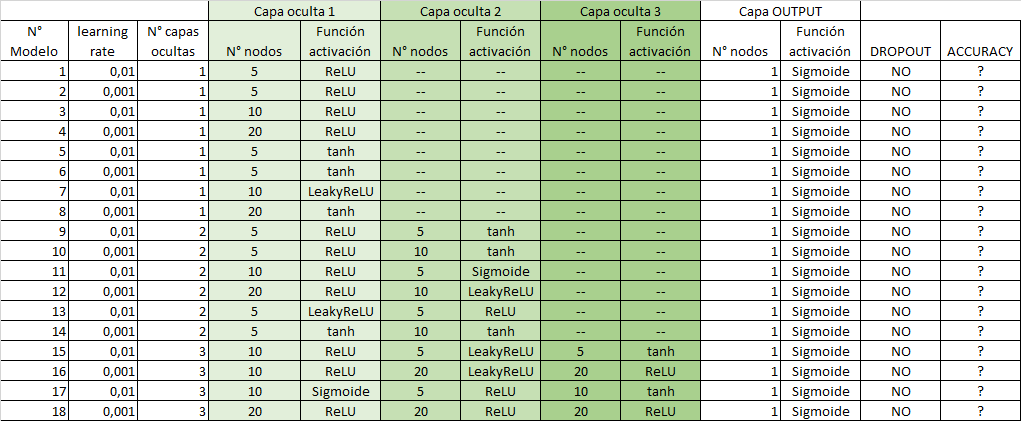

Dado que se está ante un problema de clasificación binaria, se optó porque la capa de salida siempre tuviera **1 nodo**, y se aplicara una función de activación **sigmoide** (justamente útil en casos de clasificación binaria).



### <font color='blue'>Ejecución modelos 1 al 10:</font>


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.4014 - accuracy: 0.8502
Training accuracy: 0.8344051241874695
Testing accuracy: 0.8501872420310974


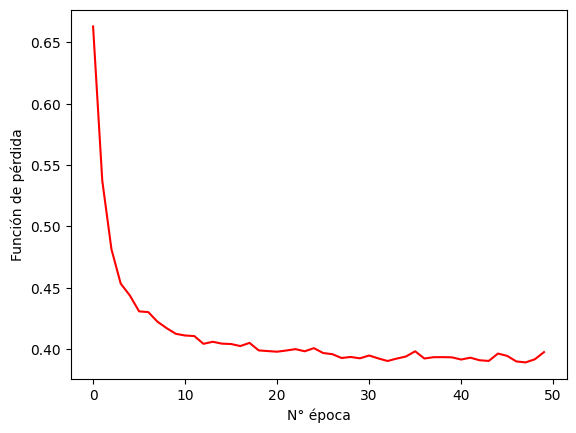

In [39]:
# MODELO 1
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.8352
Training accuracy: 0.8183279633522034
Testing accuracy: 0.8352059721946716


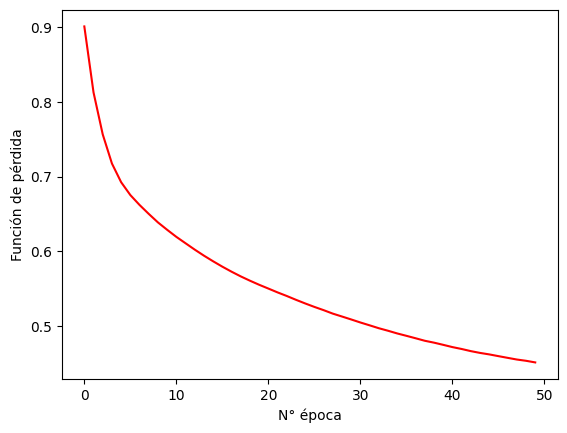

In [48]:
# MODELO 2
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8352
Training accuracy: 0.8440514206886292
Testing accuracy: 0.8352059721946716


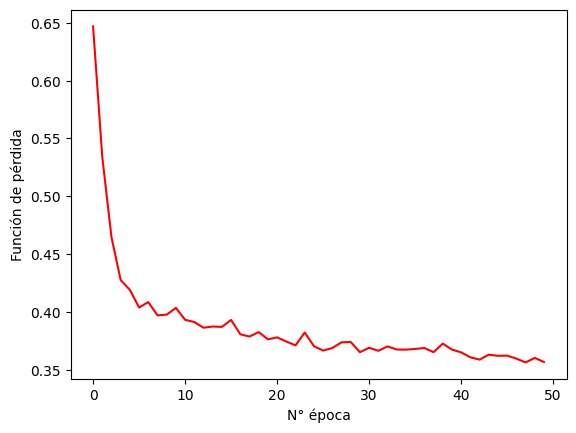

In [56]:
# MODELO 3
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.3978 - accuracy: 0.8502
Training accuracy: 0.827974259853363
Testing accuracy: 0.8501872420310974


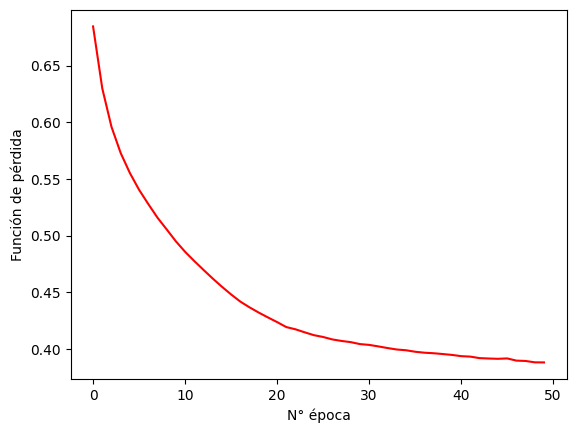

In [61]:
# MODELO 4
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8202
Training accuracy: 0.8247588276863098
Testing accuracy: 0.8202247023582458


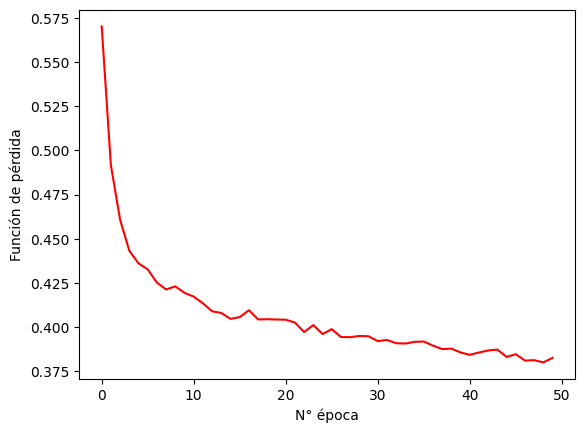

In [69]:
# MODELO 5
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.8090
Training accuracy: 0.81993567943573
Testing accuracy: 0.8089887499809265


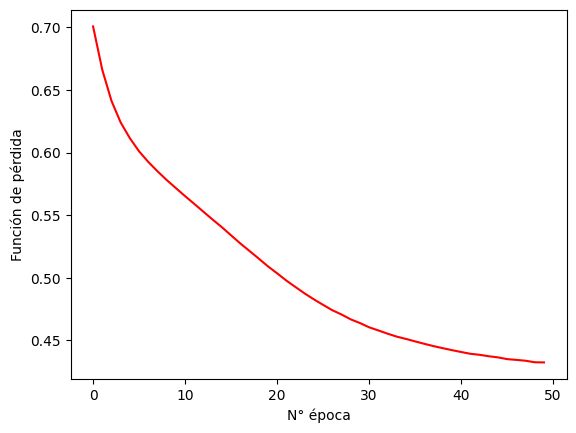

In [65]:
# MODELO 6
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8390
Training accuracy: 0.8344051241874695
Testing accuracy: 0.8389512896537781


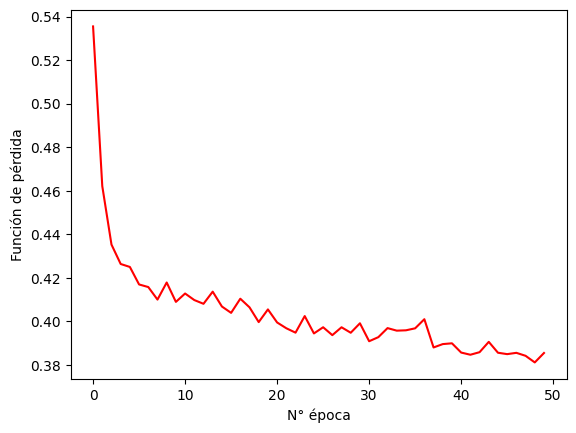

In [75]:
# MODELO 7
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='LeakyReLU'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.4287 - accuracy: 0.8202
Training accuracy: 0.8151125311851501
Testing accuracy: 0.8202247023582458


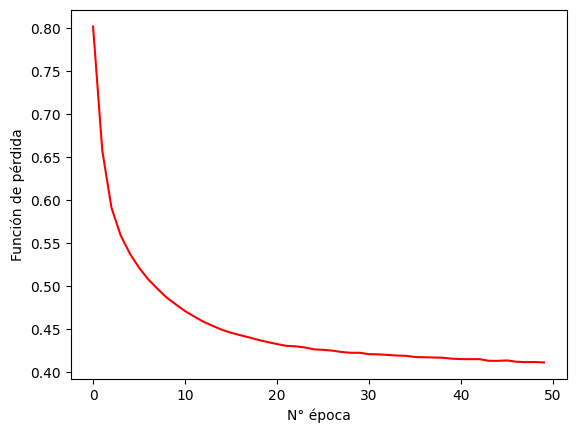

In [76]:
# MODELO 8
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.3759 - accuracy: 0.8539
Training accuracy: 0.8617363572120667
Testing accuracy: 0.8539325594902039


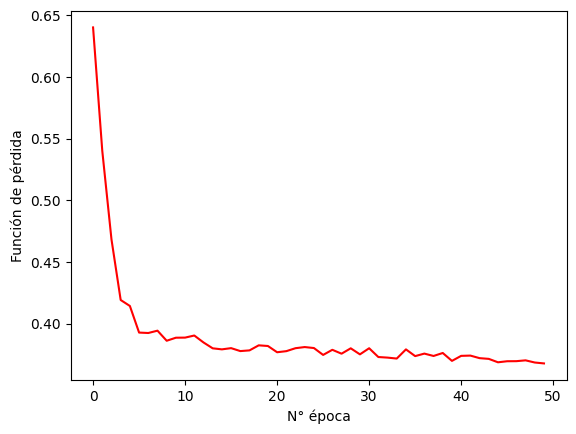

In [96]:
# MODELO 9
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=5,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4125 - accuracy: 0.8464
Training accuracy: 0.827974259853363
Testing accuracy: 0.846441924571991


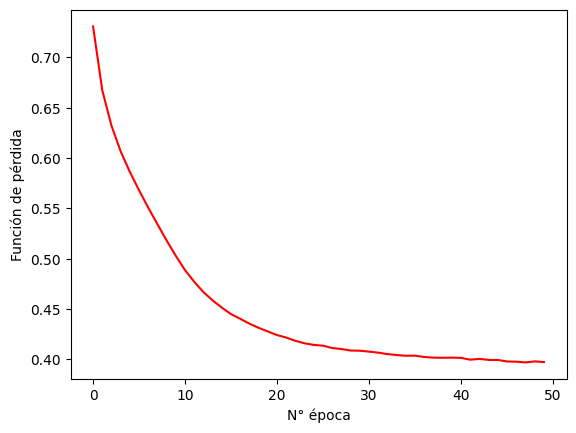

In [100]:
# MODELO 10
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=10,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

### <font color='blue'>Ejecución modelos 11 al 18:</font>


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 8ms/step - loss: 0.3964 - accuracy: 0.8352
Training accuracy: 0.8536977767944336
Testing accuracy: 0.8352059721946716


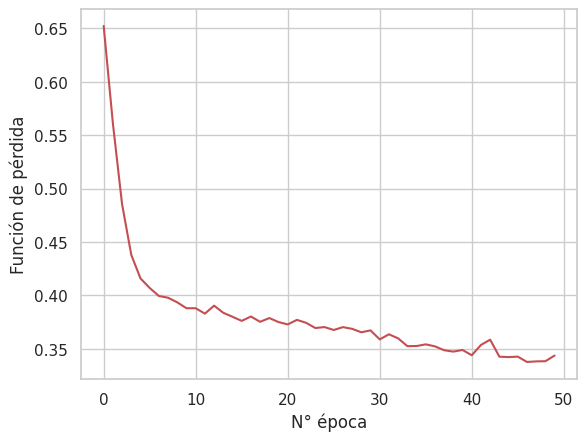

In [293]:
# MODELO 11
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=5,   activation='sigmoid'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 11ms/step - loss: 0.3894 - accuracy: 0.8614
Training accuracy: 0.8440514206886292
Testing accuracy: 0.8614231944084167


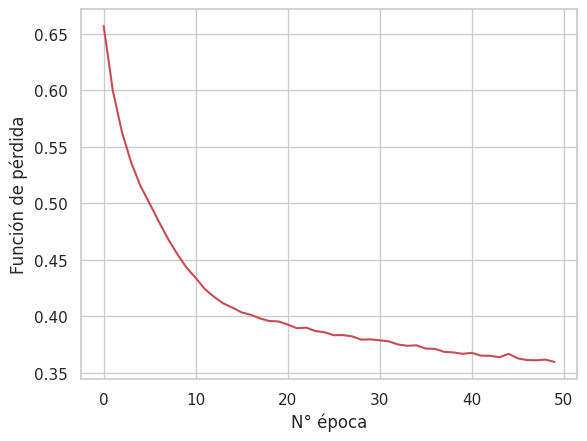

In [294]:
# MODELO 12
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=10,   activation='LeakyReLU'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8427
Training accuracy: 0.8392282724380493
Testing accuracy: 0.8426966071128845


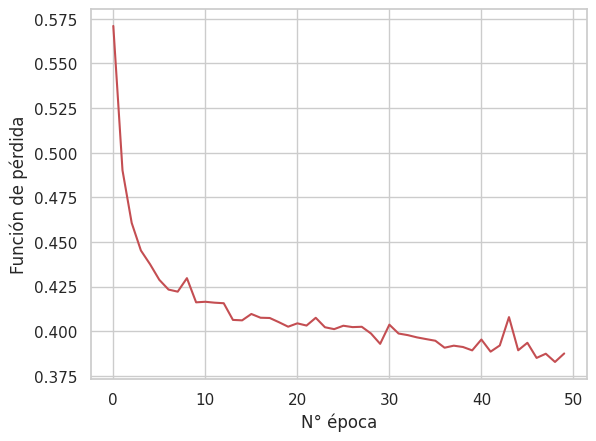

In [296]:
# MODELO 13
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='LeakyReLU'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=5,   activation='LeakyReLU'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 12ms/step - loss: 0.4326 - accuracy: 0.8277
Training accuracy: 0.8118970990180969
Testing accuracy: 0.8277153372764587


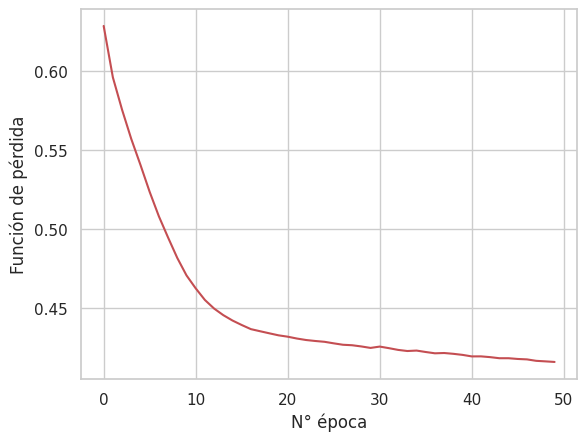

In [297]:
# MODELO 14
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='tanh'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=10,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 4ms/step - loss: 0.4001 - accuracy: 0.8502
Training accuracy: 0.8681672215461731
Testing accuracy: 0.8501872420310974


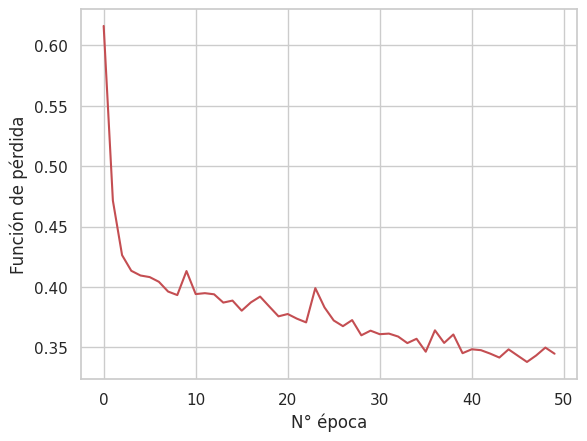

In [298]:
# MODELO 15
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=5,   activation='LeakyReLU'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=5,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8539
Training accuracy: 0.8472668528556824
Testing accuracy: 0.8539325594902039


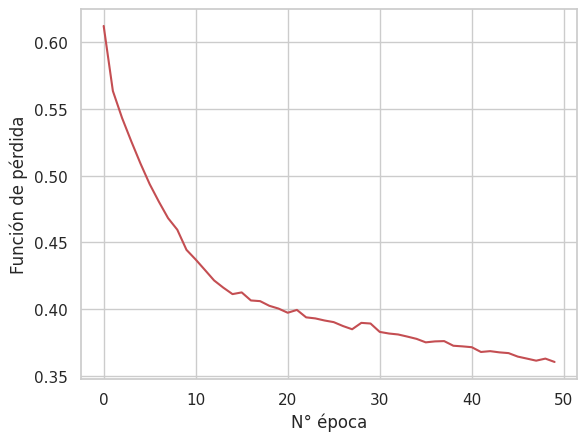

In [299]:
# MODELO 16
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=20,   activation='LeakyReLU'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=20,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.3870 - accuracy: 0.8577
Training accuracy: 0.848874568939209
Testing accuracy: 0.8576778769493103


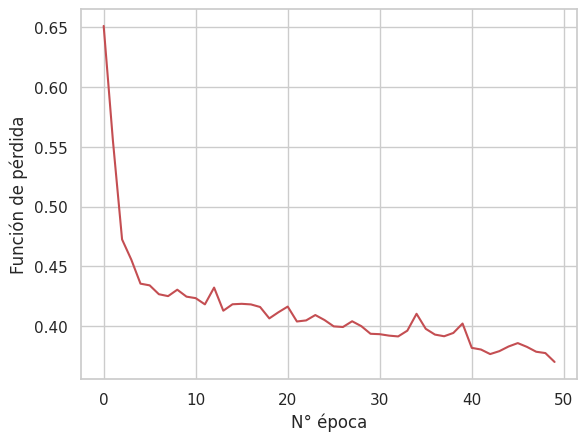

In [300]:
# MODELO 17
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='sigmoid'))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=5,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=10,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8464
Training accuracy: 0.8617363572120667
Testing accuracy: 0.846441924571991


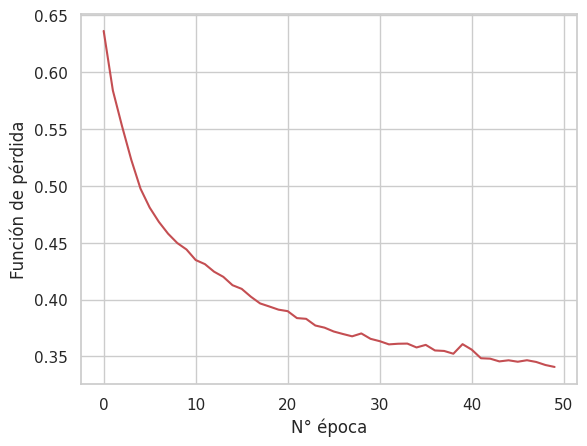

In [301]:
# MODELO 18
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=20,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=20,   activation='relu'))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

### <font color='blue'>**Comparativa 18 modelos**</font>

Al ejecutar los 18 modelos, y evaluarlos sobre la base test, el accuracy (certeza) obtenido en cada caso fue:

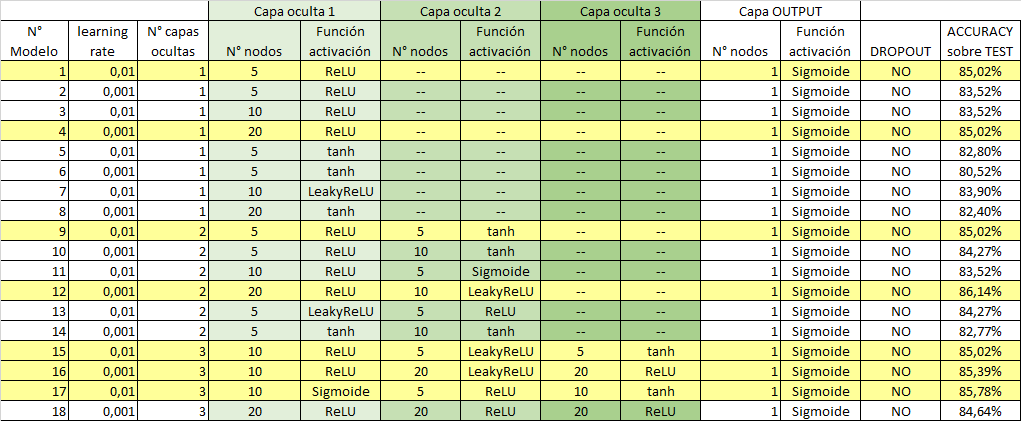

- En general se obtuvieron certezas que fluctuaron desde el 80,52% al 86,14%. Que las certezas estén concentradas en un rango relativamente pequeño habla de la confiabilidad de los resultados obtenidos (no se obtuvo una gran variabilidad entre rendimientos).

- 7 modelos pueden considerarse de mejor rendimiento, obteniendo certezas sobre el 85%.

- Se desprende que ambos learning_rates probados obtuvieron resultados similares. Ninguno obtiene mejor certeza pro sobre el otro.

- A su vez, entre estos 7 "mejores modelos" se tienen distinto número de capas ocultas y distintos tamaños de capas.



### <font color='blue'>**Regularización con técnica Dropout**</font>

A continuación el objetivo es ver si, aplicando la regularización Dropout para los 7 mejores modelos obtenidos de la etapa anterior, el rendimiento (accuracy) mejora o no en cada caso.

Recordemos que el Dropout es una técnica de regularización para RNA's que consiste en que, para cada iteración del entrenamiento, desactiva aleatoriamente un porcentaje  de las neuronas de la capa anterior de donde defino el Dropout. Esto ayudará a que las neuronas no dependan demasiado de otras, y de esa manera, disminuir la posibilidad de sobreajuste.

### <font color='blue'>Ejecución modelos con Dropout:</font>


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.3968 - accuracy: 0.8614
Training accuracy: 0.8408359885215759
Testing accuracy: 0.8614231944084167


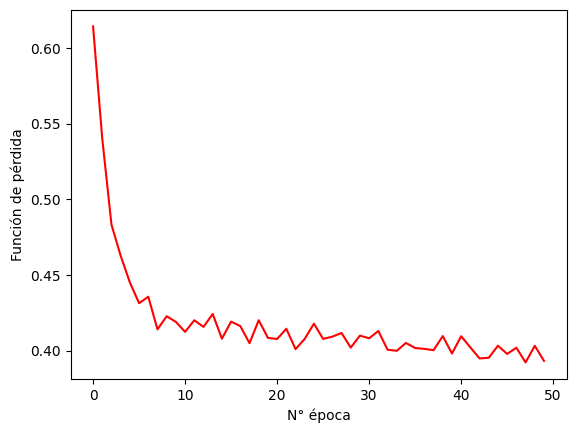

In [102]:
# MODELO 1 + DROPOUT
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.1))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.4026 - accuracy: 0.8502
Training accuracy: 0.8263665437698364
Testing accuracy: 0.8501872420310974


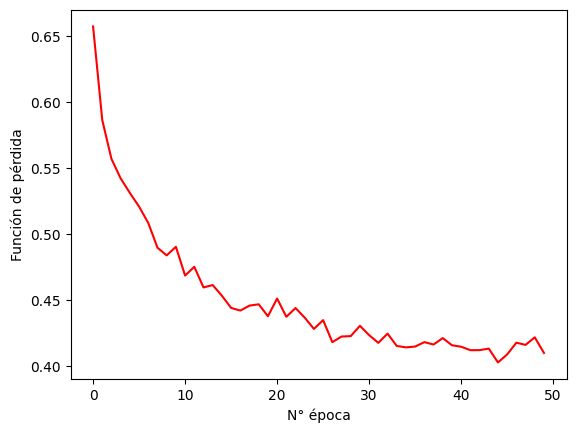

In [110]:
# MODELO 4 + DROPOUT
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8464
Training accuracy: 0.8311896920204163
Testing accuracy: 0.846441924571991


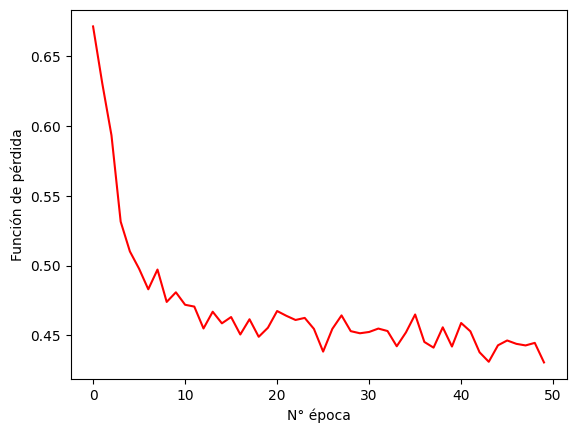

In [108]:
# MODELO 9 + DROPOUT
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=5,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.2))


#Creación de capa oculta
model.add(Dense(input_dim=5,   units=5,   activation='tanh'))


#Agregar paso dropout
model.add(Dropout(0.3))


#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.3893 - accuracy: 0.8577
Training accuracy: 0.8456591367721558
Testing accuracy: 0.8576778769493103


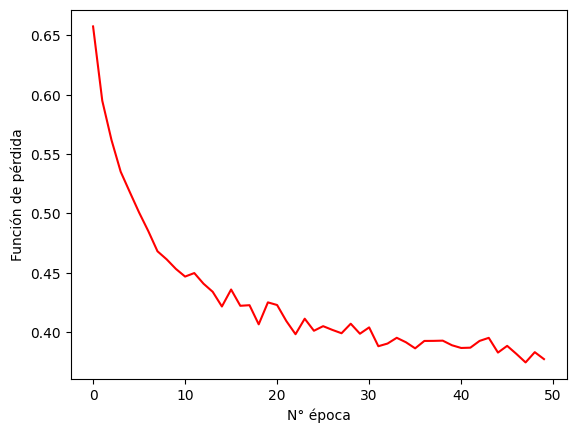

In [109]:
# MODELO 12 + dropout
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=10,   activation='LeakyReLU'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8502
Training accuracy: 0.8504823446273804
Testing accuracy: 0.8501872420310974


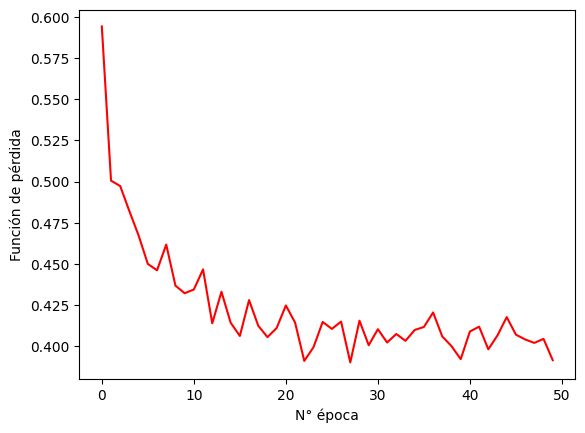

In [111]:
# MODELO 15 + DROPOUT
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=5,   activation='LeakyReLU'))

#Agregar paso dropout
model.add(Dropout(0.2))


#Creación de capa oculta
model.add(Dense(input_dim=5,   units=5,   activation='tanh'))

#Creación de capa de salida
model.add(Dense(input_dim=5, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8427
Training accuracy: 0.8392282724380493
Testing accuracy: 0.8426966071128845


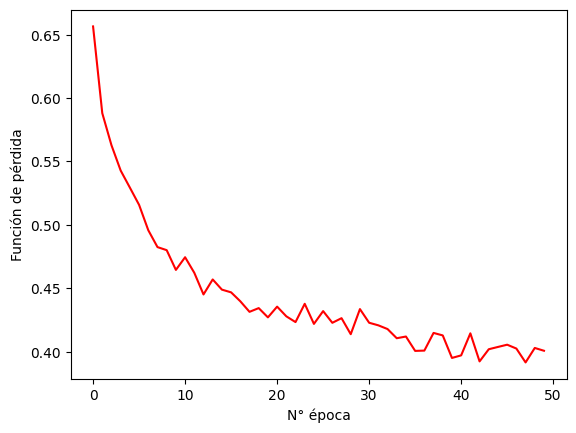

In [114]:
# MODELO 16 + DROPOUT
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=20,   activation='LeakyReLU'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=20,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.3))

#Creación de capa de salida
model.add(Dense(input_dim=20, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 4ms/step - loss: 0.4034 - accuracy: 0.8427
Training accuracy: 0.8327974081039429
Testing accuracy: 0.8426966071128845


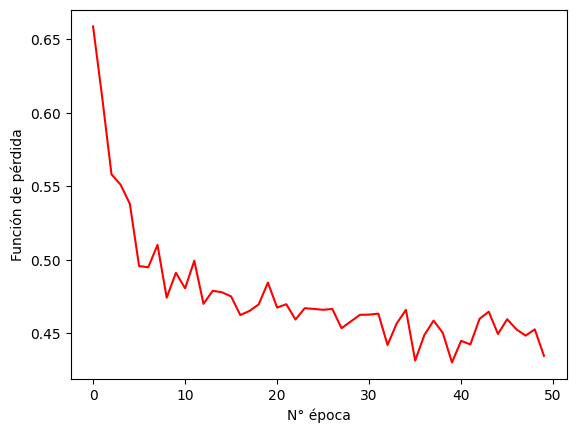

In [124]:
# MODELO 17 + DROPOUT
#Parámetros
learning_rate = 0.01
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=10,   activation='sigmoid'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa oculta
model.add(Dense(input_dim=10,   units=5,   activation='relu'))

#Agregar paso dropout
model.add(Dropout(0.2))

#Creación de capa oculta
model.add(Dense(input_dim=5,   units=10,   activation='tanh'))

#Agregar paso dropout
model.add(Dropout(0.2))


#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

##Los resultados en el accuracy para cada modelo en que se aplicó Dropout:

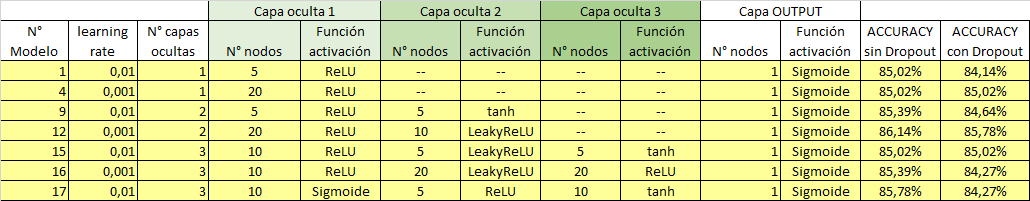

Al observar los distintos **"accuracy" se ve que al aplicar Dropout, en la mayoría de los casos se mantiene, o incluso disminuye un poco la certeza.**

Esto podría deberse a que la técnica de Dropout es mucho más **útil en modelos con mucha cantidad de datos y en redes más complejas (muchas capas y nodos).**

En nuestro caso la data de entrenamiento es alrededor de 600 observaciones, y el máximo número de capas ocultas en 3, con un máximo número de nodos de 20. Quizá por estas dimensiones es que regularizar con Dropout no implicó un cambio drástico respecto a los resultados originales.

### <font color='blue'>**Selección de modelo y predicción para los 3 integrantes de grupo**</font>

- El modelo escogido será el N°12, sin Dropout, que consiste en una arquitectura de 2 capas ocultas más una de salida. Esto, pues este modelo fue el que obtuvo un mayor accuracy entre sus similares.


*******************
Evaluar accuracy (certeza)
9/9 [==============================] - 0s 5ms/step - loss: 0.3855 - accuracy: 0.8614
Training accuracy: 0.8440514206886292
Testing accuracy: 0.8614231944084167


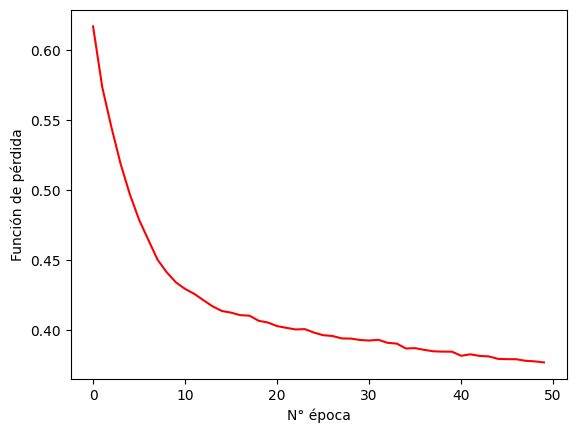

In [130]:
#Entrenamos el modelo nuevamente

# MODELO 12
#Parámetros
learning_rate = 0.001
batch_size = 16

#Construcción de la red
model = Sequential()

#Creación de capa oculta
model.add(Dense(input_dim=9,   units=20,   activation='relu'))

#Creación de capa oculta
model.add(Dense(input_dim=20,   units=10,   activation='LeakyReLU'))


#Creación de capa de salida
model.add(Dense(input_dim=10, units=1,activation='sigmoid'))


#*******************************************************************************************

# Definición de función de pérdida y optimizador
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

#Entrenamiento del modelo:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=False)

print('')
print('*******************')
print('Evaluar accuracy (certeza)')


# Evaluación de accuracy
train_acc = model.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

Por otra parte agregamos al dataframe original los casos con los 3 integrantes del grupo y sus variables:

In [137]:
nueva_fila1 = {'Survived': 99, 'Pclass': 2, 'Sex': 'male', 'Age': 33, 'SibSp': 0, 'Parch': 0, 'Fare': 14.5 , 'Embarked': 'S', 'N_acompañantes': 0} #Fernando Lagos
nueva_fila2 = {'Survived': 99, 'Pclass': 1, 'Sex': 'male', 'Age': 40, 'SibSp': 1, 'Parch': 2, 'Fare': 123.7 , 'Embarked': 'C', 'N_acompañantes': 3} #David Pastene
nueva_fila3 = {'Survived': 99, 'Pclass': 3, 'Sex': 'female', 'Age': 34, 'SibSp': 2, 'Parch': 0, 'Fare': 9.22 , 'Embarked': 'Q', 'N_acompañantes': 2} #Victoria Patiño

data3 = data3.append(nueva_fila1, ignore_index=True)
data3 = data3.append(nueva_fila2, ignore_index=True)
data3 = data3.append(nueva_fila3, ignore_index=True)

<ipython-input-137-63e56280ef0e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data3 = data3.append(nueva_fila1, ignore_index=True)
<ipython-input-137-63e56280ef0e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data3 = data3.append(nueva_fila2, ignore_index=True)
<ipython-input-137-63e56280ef0e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data3 = data3.append(nueva_fila3, ignore_index=True)


In [138]:
print(data3.shape) #Quedó con 892 observaciones
data3.tail()

(892, 9)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,N_acompañantes
887,1,1,male,26.0,0,0,30.00,C,0
888,0,3,male,32.0,0,0,7.75,Q,0
889,99,2,male,33.0,0,0,14.50,S,0
890,99,1,male,40.0,1,2,123.70,C,3
891,99,3,female,34.0,2,0,9.22,Q,2


In [139]:
#Volvemos a decodificar y estandarizar

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SibSp', 'Parch', 'Fare','Age','N_acompañantes','Pclass']),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), ['Sex','Embarked'])
    ])

#En OneHotEncoder, con drop='first' hago que se elimine una de las variables dummy del feature, impidiendo la multicolinealidad perfecta.

#Variables independientes:
features = ['SibSp', 'Parch', 'Fare','Age','N_acompañantes','Pclass','Sex','Embarked']

#Aplico preprocesador a variables independientes:
data_transformada= preprocessor.fit_transform(data3[features])

#Paso a dataframe:
data4 = pd.DataFrame(data_transformada, columns=preprocessor.get_feature_names_out())
data4['Survived'] = data3['Survived']
data4.tail()

,num__SibSp,num__Parch,num__Fare,num__Age,num__N_acompañantes,num__Pclass,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S,Survived
887,-0.476864,-0.475119,-0.043349,-0.253640,-0.563561,-1.570699,1.0,0.0,0.0,1
888,-0.476864,-0.475119,-0.491124,0.161328,-0.563561,0.826330,1.0,1.0,0.0,0
889,-0.476864,-0.475119,-0.355282,0.230489,-0.563561,-0.372184,1.0,0.0,1.0,99
890,0.430092,2.003280,1.842340,0.714617,1.295981,-1.570699,1.0,0.0,0.0,99
891,1.337049,-0.475119,-0.461541,0.299650,0.676134,0.826330,0.0,1.0,0.0,99


In [142]:
data_aux = data4.drop('Survived', axis=1)
data_aux.tail()

,num__SibSp,num__Parch,num__Fare,num__Age,num__N_acompañantes,num__Pclass,cat__Sex_male,cat__Embarked_Q,cat__Embarked_S
887,-0.476864,-0.475119,-0.043349,-0.253640,-0.563561,-1.570699,1.0,0.0,0.0
888,-0.476864,-0.475119,-0.491124,0.161328,-0.563561,0.826330,1.0,1.0,0.0
889,-0.476864,-0.475119,-0.355282,0.230489,-0.563561,-0.372184,1.0,0.0,1.0
890,0.430092,2.003280,1.842340,0.714617,1.295981,-1.570699,1.0,0.0,0.0
891,1.337049,-0.475119,-0.461541,0.299650,0.676134,0.826330,0.0,1.0,0.0


In [146]:
indices_a_filtrar = [889,890,891]
model.predict(data_aux.loc[indices_a_filtrar])

1/1 [==============================] - 0s 142ms/step


array([[0.13908337],
       [0.2687876 ],
       [0.28105518]], dtype=float32)

Para los 3 integrantes, si vemos el output de la función de salida (sigmoidea), y si establecemos el punto de corte en 0,5, se tiene que los 3 integrante no sobrevivirían al Titanic (pues están más cerca del valor 0 que del 1)

- El integrante Fernando lagos no es de primera clase y es hombre, además de haber pagado un valor bajo pro su ticket. Todo ello podría explicar que es quien tiene la menor probabilidad de sobrevivir (13,9%).

- Luego David Pastene, pese a pertenecer a primera clase, haber pagado un precio alto por el ticket y haberse embarcado en el puerto más pudiente, el hecho de ser hombre al parecer el bajó a su probabilidad de osbrevivencia, quedando en 26,9%.

- Por último Victoria Patiño, pese a ser mujer (se sabe que mujeres tienen una tasa de sobrevivencia mucho mayor que los hombres), le juega en contra ser de tercera clase, haber pagado muy poco por su ticket y haberse embarcado en un puerto ligado a la tercera clase. Por ello su probabilidad, aunque es la mayor de los 3, queda en 28,1%.

## <font color='blue'>**V. Conclusiones**</font>

1. Consistencia en los resultados de las redes neuronales: si bien se sabe que al utilizar keras no se puede fijar una semilla, y por ende un entrenamiento arroja resultados diferentes al correr de nuevo, se observa que todas las redes entrenadas poseen en general un accuracy que fluctúa entre el 81 y el 86%, lo que habla que en general convergen bien y no son inestables. Además una certeza para un problema de clasificación entre 81% y 86% puede considerarse como aceptable.

2. Al aplicar regularización tipo dropout para evitar potencial overfitting en el entrenamiento no se obtuvieron grandes cambios respecto a los modelos sin dropout, esto posiblemente se deba a que esta técnica es útil para modelos con gran cantidad de datos y gran cantidad de capas y nodos (y por ende de conexiones). En nuestro caso, tanto el dataset como la estructura de las redes son de dimensiones reducidas.

3. Al observar los rendimientos de los modelos con los 2 learning_rate probados (0.01 y 0.001) se tiene que ninguno es especialmente mejor que el otro. A ambos pasos, el modelo tiende a converger a lo mismo.

4. En cuanto a la estructura de la red, tampoco se observó que el número de capas o nodos influyera de manera significativa en el accuracy.

5. En el presente trabajo se resolvió un problema de clasificación binaria con un número de variables bastante acotado, es decir, un modelo no muy complejo. Si bien la red neuronal funciona para estos casos, en la práctica probablemente resultará más útil aplicar para este tipo de problemas otro tipo de algoritmos supervisados como regresión logística o árbol de decisión. Estos resultan más simples de aplicar y no tienen el efecto "caja negra" por lo que se puede explicar, a partir de las salidas, cómo influye cada variable independiente en la variable objetivo. La red neuronal se sugiere para problemas de mayor dimensionalidad.

6. Si bien este no es un problema muy complejo, valdría la pena probar si al aplicar otras técnicas de regularización como L1,  L2 o normalización por batcj, implica una mejora en el accuracy obtenido.

7. Por otra parte, a pesar que en todos los entrenamientos se ocupó el algoritmo optimizador ADAM, por arrojar muy buenos resultados en general, valdría la pena probar otros como SGD, momentum, RMSprop, ADAGRAD o ADADELTA, para ver su efecto en el rendimiento de cada modelo.